In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# Add SRC to Python path
sys.path.append(str(Path.cwd().parent / "src"))

from data_prep import load_and_prepare_data

import xgboost as xgb
print("XGBoost Version:", xgb.__version__)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


XGBoost Version: 1.7.6


In [2]:
print("Loading and preparing dataset with SMOTENC...")

csv_path = "../data/external/FPA_FOD_Plus.csv"

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_and_prepare_data(
    csv_path,
    smote_strategy="smotenc"   # Options: "smotenc", "random", "none"
)

print("\nShapes:")
print("Training:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)

Loading and preparing dataset with SMOTENC...

Loading data with Polars...
File loaded into Pandas. Shape: (2302521, 308)

Pre-Sampling before SMOTENC (500k small class)...

Original class distribution:
target
0    1345082
1      33560
2       2210
3        660
Name: count, dtype: int64

Pre-sampled total rows: 536,430

Applying SMOTENC oversampling

Shapes:
Training: (2000000, 49) (2000000,)
Validation: (460504, 49) (460504,)
Test: (460505, 49) (460505,)


In [3]:
print("\nBuilding XGBoost Model")

params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",    # FAST on CPU
    "n_estimators": 350
}

model_xgb = xgb.XGBClassifier(**params)


Building XGBoost Model


In [5]:
print("\nTraining XGBoost w early stopping...\n")

eval_set = [(X_train, Y_train), (X_val, Y_val)]

model_xgb.fit(
    X_train, Y_train,
    eval_set=eval_set,
    early_stopping_rounds=15,
    verbose=True
)


print("\nTraining Complete")


Training XGBoost w early stopping...



/Users/nedim/miniforge3/envs/tf_cpu_mids/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.35332	validation_1-mlogloss:1.34719
[1]	validation_0-mlogloss:1.31934	validation_1-mlogloss:1.30790
[2]	validation_0-mlogloss:1.28965	validation_1-mlogloss:1.27215
[3]	validation_0-mlogloss:1.26073	validation_1-mlogloss:1.23973
[4]	validation_0-mlogloss:1.23376	validation_1-mlogloss:1.20829
[5]	validation_0-mlogloss:1.20745	validation_1-mlogloss:1.17865
[6]	validation_0-mlogloss:1.18359	validation_1-mlogloss:1.14888
[7]	validation_0-mlogloss:1.16056	validation_1-mlogloss:1.12327
[8]	validation_0-mlogloss:1.13957	validation_1-mlogloss:1.10014
[9]	validation_0-mlogloss:1.11976	validation_1-mlogloss:1.07655
[10]	validation_0-mlogloss:1.10022	validation_1-mlogloss:1.05449
[11]	validation_0-mlogloss:1.08127	validation_1-mlogloss:1.03268
[12]	validation_0-mlogloss:1.06362	validation_1-mlogloss:1.01346
[13]	validation_0-mlogloss:1.04711	validation_1-mlogloss:0.99526
[14]	validation_0-mlogloss:1.03095	validation_1-mlogloss:0.97685
[15]	validation_0-mlogloss:1.01619	

In [6]:
print("\nEvaluating on Validation Set")

y_pred_val_prob = model_xgb.predict_proba(X_val)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

print("Validation Accuracy:", accuracy_score(Y_val, y_pred_val))
print("\nClassification Report:\n")
print(classification_report(Y_val, y_pred_val))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(Y_val, y_pred_val)
print(cm)


Evaluating on Validation Set
Validation Accuracy: 0.9371514688254609

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    448361
           1       0.12      0.15      0.13     11185
           2       0.02      0.15      0.04       738
           3       0.03      0.26      0.05       220

    accuracy                           0.94    460504
   macro avg       0.29      0.38      0.30    460504
weighted avg       0.96      0.94      0.95    460504


Confusion Matrix:

[[429666  13023   4211   1461]
 [  8585   1728    574    298]
 [   445     96    111     86]
 [    95     20     48     57]]


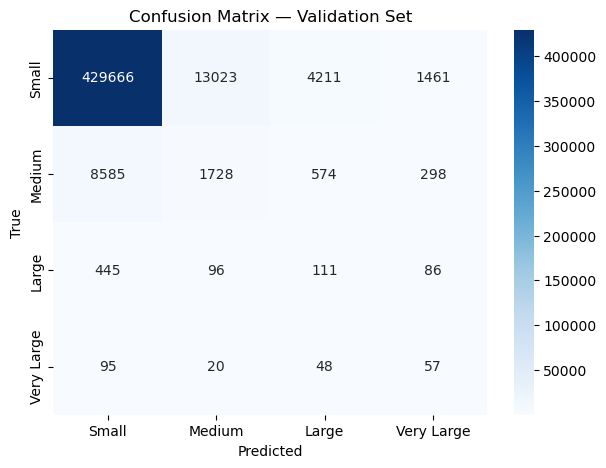

In [7]:
labels = ["Small", "Medium", "Large", "Very Large"]

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()